# 🚀 Model Optimization
## Student Dropout Prediction Project

**Goal:** Improve model accuracy (Target: >83%) by tuning hyperparameters of the top performing models (XGBoost & Random Forest).

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
import joblib
import sys
import os
import importlib
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path
sys.path.append('..')
import config
importlib.reload(config)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Load Processed Data

In [2]:
try:
    train_df = pd.read_csv(config.TRAIN_DATA_PATH)
    test_df = pd.read_csv(config.TEST_DATA_PATH)
    
    X_train = train_df.drop(columns=['Target'])
    y_train = train_df['Target']
    X_test = test_df.drop(columns=['Target'])
    y_test = test_df['Target']
    
    print(f"✓ Data loaded successfully")
    print(f"Train shape: {X_train.shape}")
    print(f"Test shape:  {X_test.shape}")
except FileNotFoundError:
    print("❌ Error: Processed data not found. Run 02_data_preprocessing.ipynb first.")

✓ Data loaded successfully
Train shape: (10783, 21)
Test shape:  (2696, 21)


## 2. Define Hyperparameter Grids

In [4]:
# XGBoost Grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Random Forest Grid
rf_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

## 3. Tune XGBoost (RandomizedSearch)

In [5]:
print("⏳ Tuning XGBoost... (This may take a while)")

xgb = XGBClassifier(random_state=config.RANDOM_STATE, n_jobs=-1)

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=config.RANDOM_STATE,
    n_jobs=-1
)

xgb_random.fit(X_train, y_train)

print(f"\n✓ Best XGBoost Parameters: {xgb_random.best_params_}")
print(f"✓ Best CV Accuracy: {xgb_random.best_score_:.4f}")

⏳ Tuning XGBoost... (This may take a while)
Fitting 3 folds for each of 50 candidates, totalling 150 fits

✓ Best XGBoost Parameters: {'subsample': 0.7, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 1.0}
✓ Best CV Accuracy: 0.7337


## 4. Tune Random Forest (RandomizedSearch)

In [6]:
print("\n⏳ Tuning Random Forest... (This may take a while)")

rf = RandomForestClassifier(random_state=config.RANDOM_STATE, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=30,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=config.RANDOM_STATE,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

print(f"\n✓ Best Random Forest Parameters: {rf_random.best_params_}")
print(f"✓ Best CV Accuracy: {rf_random.best_score_:.4f}")


⏳ Tuning Random Forest... (This may take a while)
Fitting 3 folds for each of 30 candidates, totalling 90 fits

✓ Best Random Forest Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}
✓ Best CV Accuracy: 0.7395


## 5. Evaluate Tuned Models

In [7]:
best_xgb = xgb_random.best_estimator_
best_rf = rf_random.best_estimator_

# Evaluate XGBoost
y_pred_xgb = best_xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\n🏆 Tuned XGBoost Test Accuracy: {acc_xgb:.4f}")

# Evaluate Random Forest
y_pred_rf = best_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"🏆 Tuned Random Forest Test Accuracy: {acc_rf:.4f}")

# Select Winner
if acc_xgb > acc_rf:
    final_model = best_xgb
    final_name = "XGBoost_Tuned"
    print(f"\n✅ XGBoost is the winner!")
else:
    final_model = best_rf
    final_name = "RandomForest_Tuned"
    print(f"\n✅ Random Forest is the winner!")


🏆 Tuned XGBoost Test Accuracy: 0.7596
🏆 Tuned Random Forest Test Accuracy: 0.7708

✅ Random Forest is the winner!


## 6. Detailed Evaluation (Winner)

Detailed Report for RandomForest_Tuned:
              precision    recall  f1-score   support

     Dropout       0.79      0.73      0.76       898
    Enrolled       0.81      0.81      0.81       899
    Graduate       0.72      0.77      0.74       899

    accuracy                           0.77      2696
   macro avg       0.77      0.77      0.77      2696
weighted avg       0.77      0.77      0.77      2696



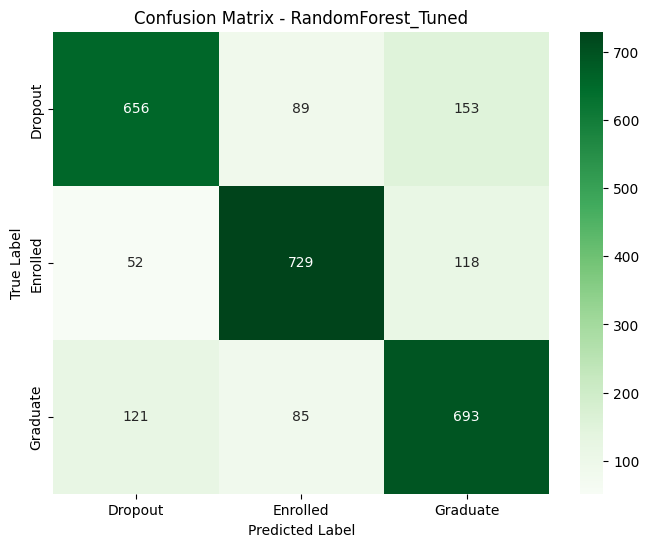

In [8]:
print(f"Detailed Report for {final_name}:")
y_pred_final = final_model.predict(X_test)
print(classification_report(y_test, y_pred_final, target_names=['Dropout', 'Enrolled', 'Graduate']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Dropout', 'Enrolled', 'Graduate'],
            yticklabels=['Dropout', 'Enrolled', 'Graduate'])
plt.title(f'Confusion Matrix - {final_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 7. Save Final Model

In [9]:
save_path = config.MODEL_DIR / "best_model_tuned.pkl"
joblib.dump(final_model, save_path)
print(f"✓ Saved tuned model to: {save_path}")

# Overwrite the app model if it's better
joblib.dump(final_model, config.MODEL_DIR / "best_model.pkl")
print(f"✓ Updated default app model.")

✓ Saved tuned model to: D:\Santosh_minor\notebooks\..\models\best_model_tuned.pkl
✓ Updated default app model.
